In [24]:
import pandas as pd
import matplotlib.pyplot as plt

In [25]:
df = pd.read_csv("./data/final_dataset.csv")

df['time'] = pd.to_datetime(df['time'], utc = True)
df = df.set_index('time')

In [26]:
# Define a function to plot different types of time-series

def plot_ts(df: pd.DataFrame, column: str = None, series: pd.Series = None,
                label: str = None, ylabel: str = None, title: str = None,
                start = None, end = None):
    """
    Plots a time series from either:
      - A column in a DataFrame indexed by time, OR
      - A standalone pandas Series indexed by time.

    Parameters:
        df (pd.DataFrame): DataFrame containing the time series.
        column (str): Column name to plot from df.
        series (pd.Series): Standalone time series to plot.
        label (str): Legend label for the plot.
        ylabel (str): Y-axis label.
        title (str): Title of the plot.
        start, end: Time range for plotting (can be ints, timestamps, or None).
    """
    _, ax = plt.subplots(figsize=(30, 12))
    ax.set_xlabel('Time', fontsize=16)

    # Plot from DataFrame
    if df is not None and column is not None:
        ax.plot(df.loc[start:end, column], label=label)
        ax.set_ylabel(ylabel, fontsize=16)

    # Plot from Series
    if series is not None and not series.empty:
        ax.plot(series.loc[start:end], label=label)
        ax.set_ylabel(ylabel, fontsize=16)

    # Labels & grid
    if label:
        ax.legend(fontsize=16)
    if title:
        ax.set_title(title, fontsize=24)
    ax.grid(True)

    return ax

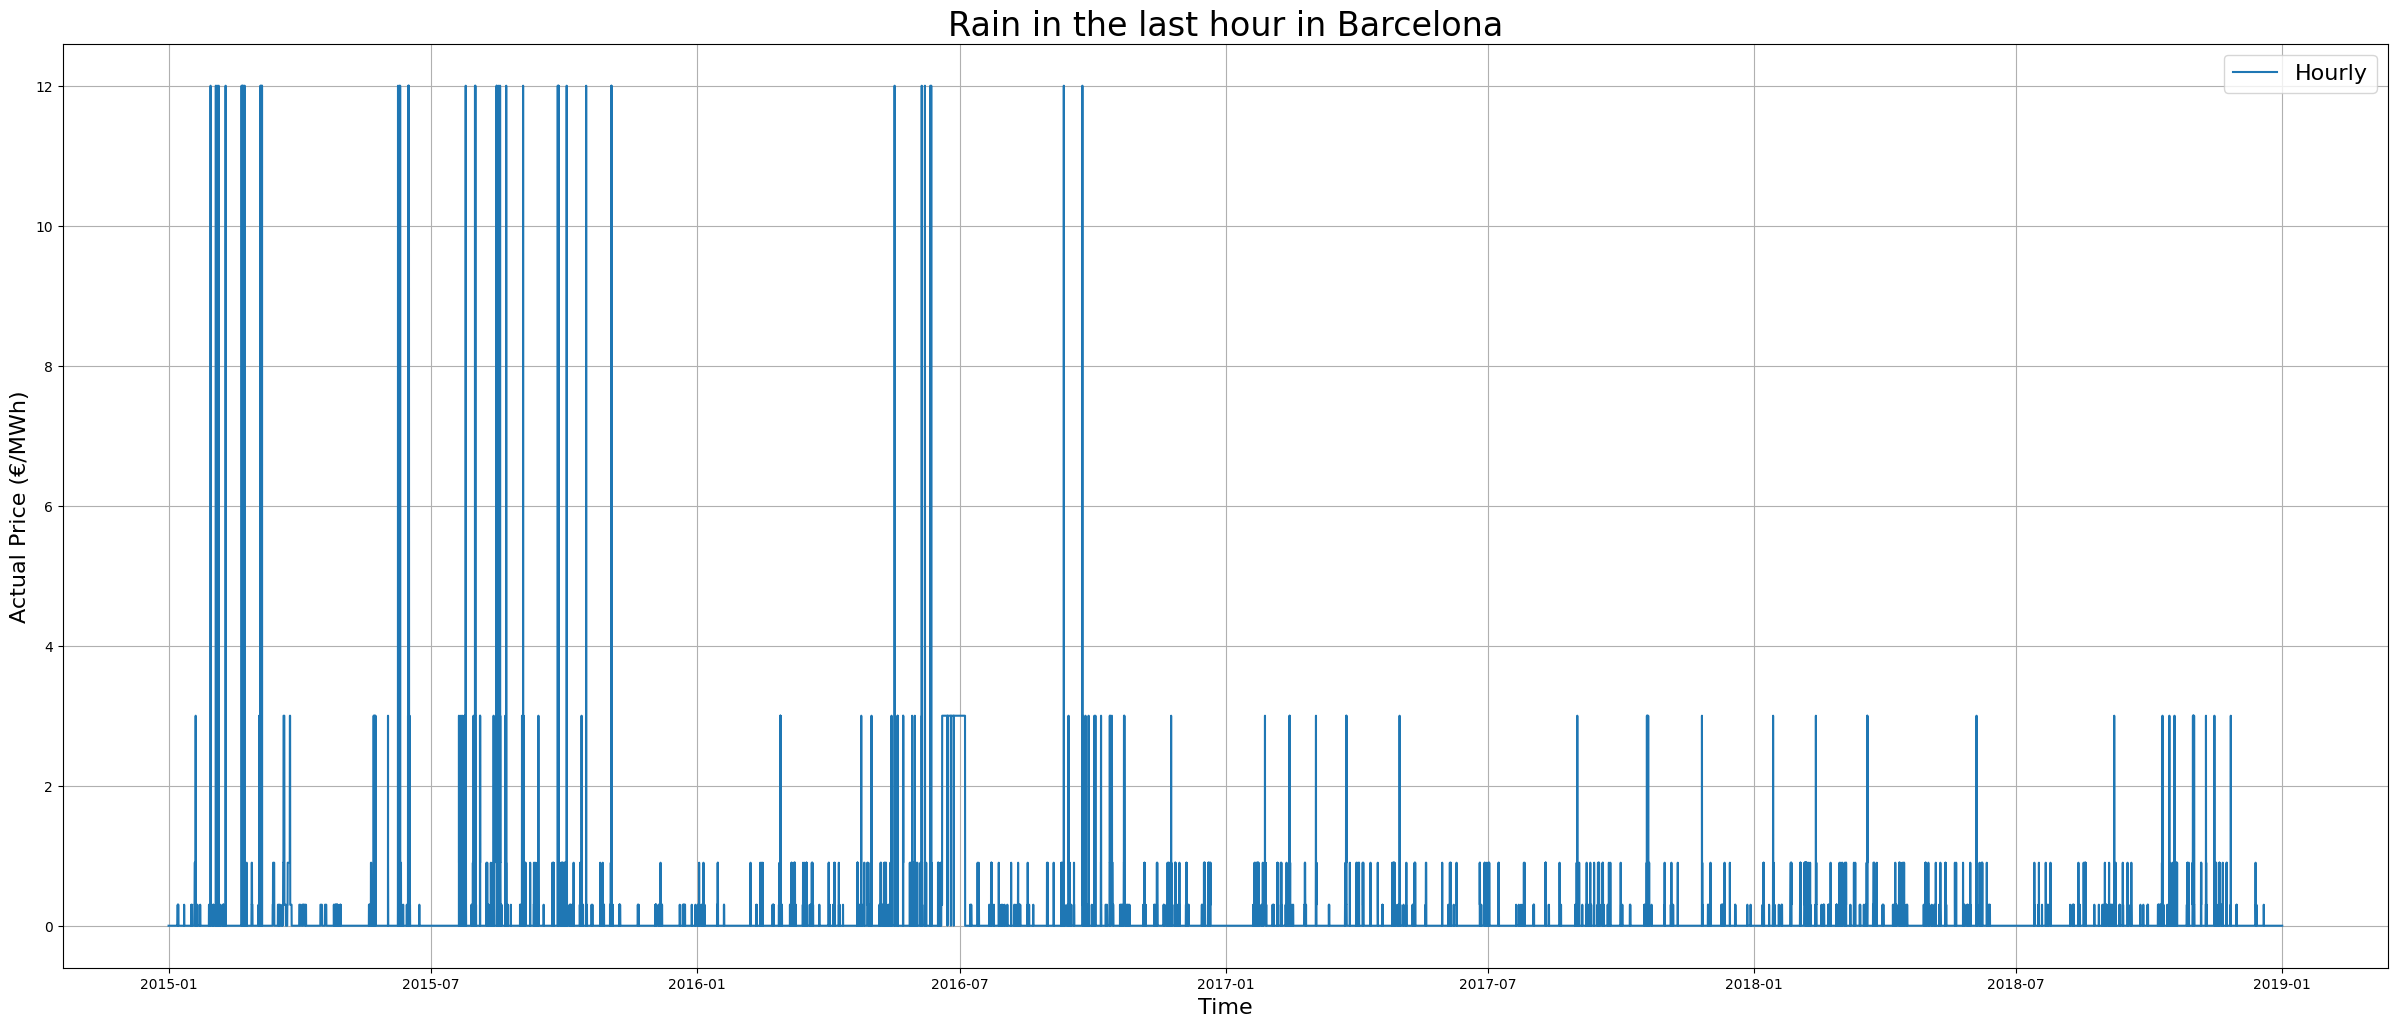

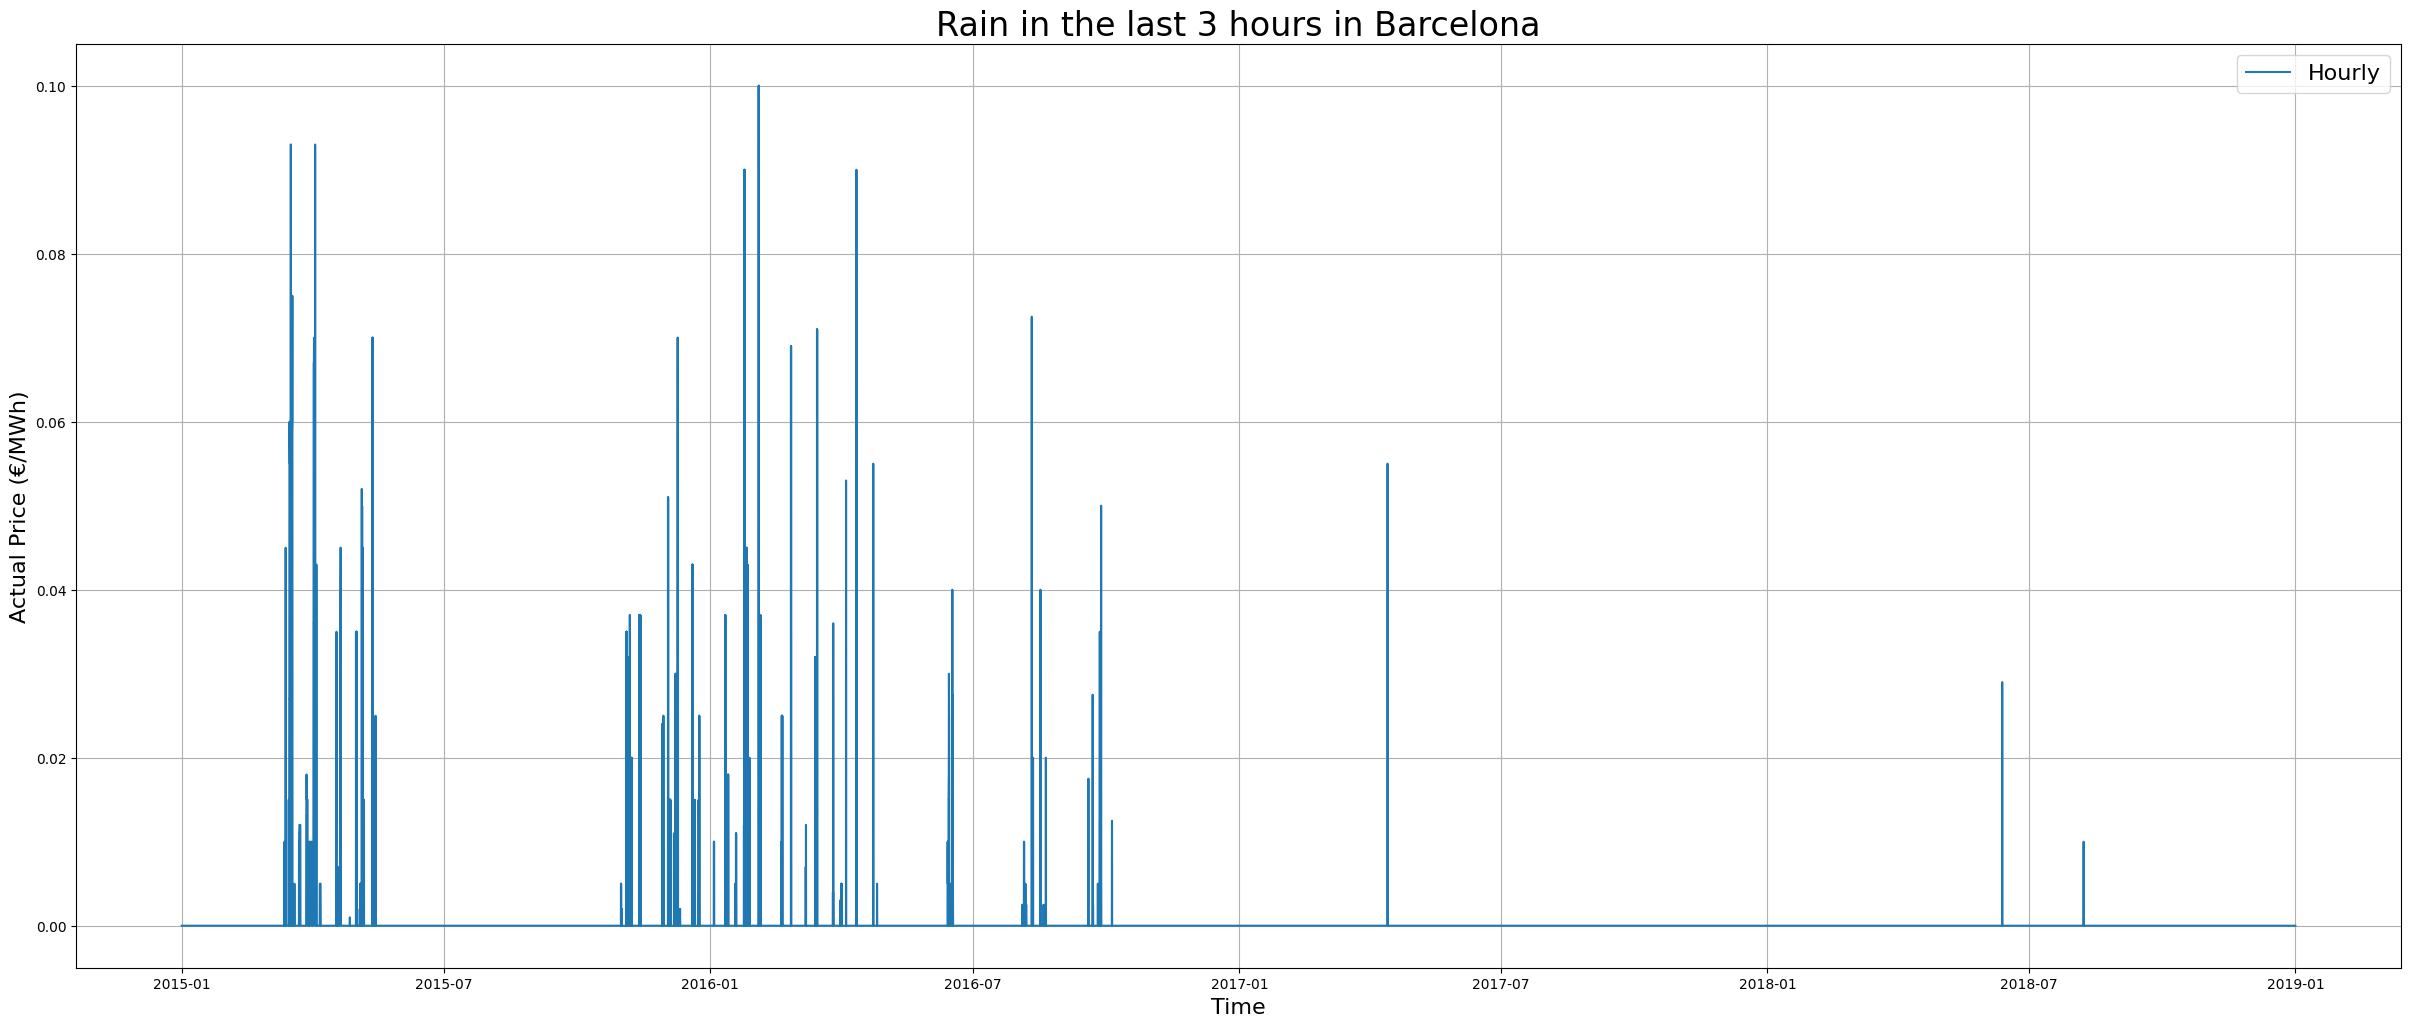

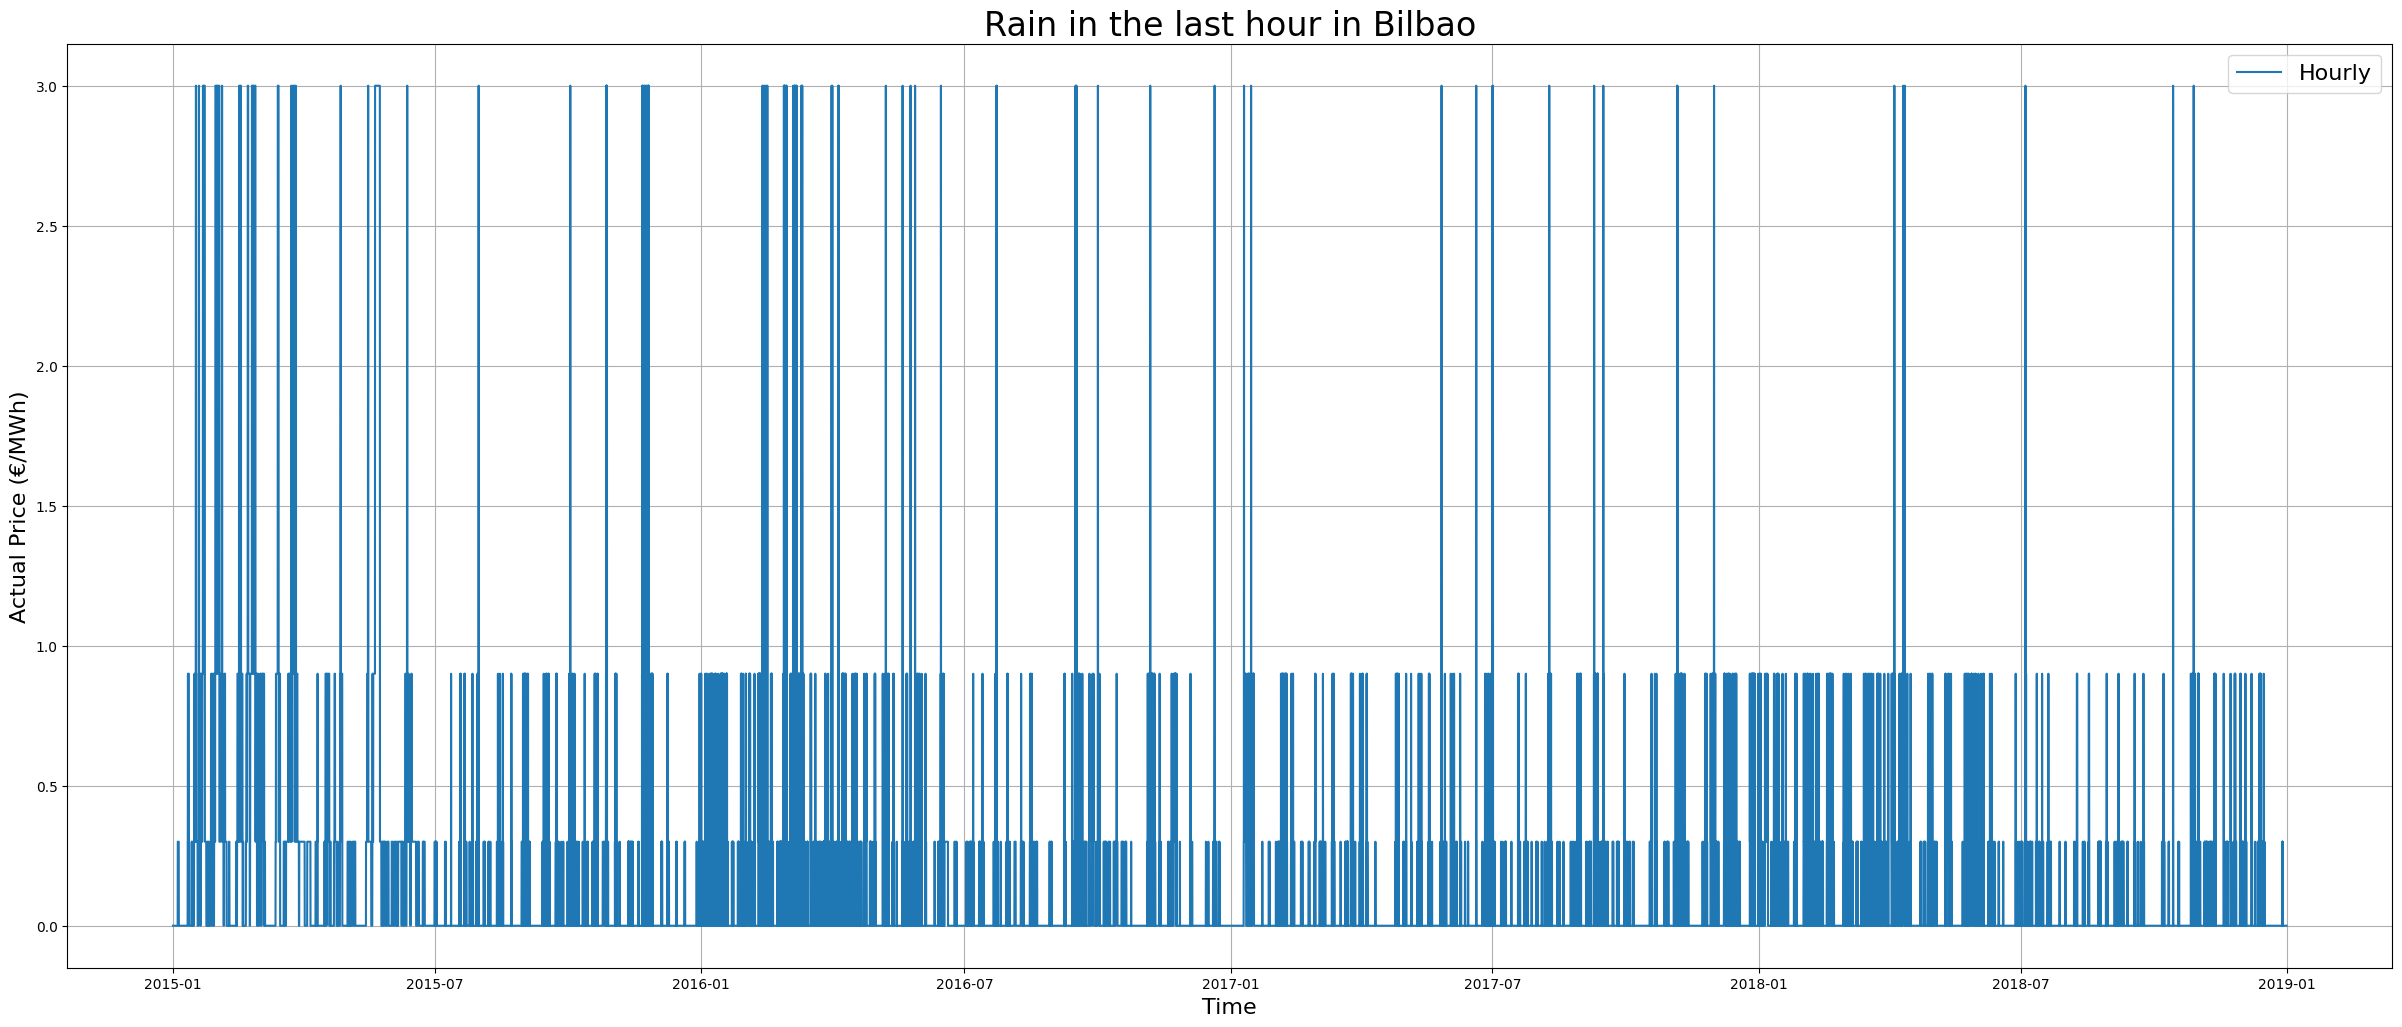

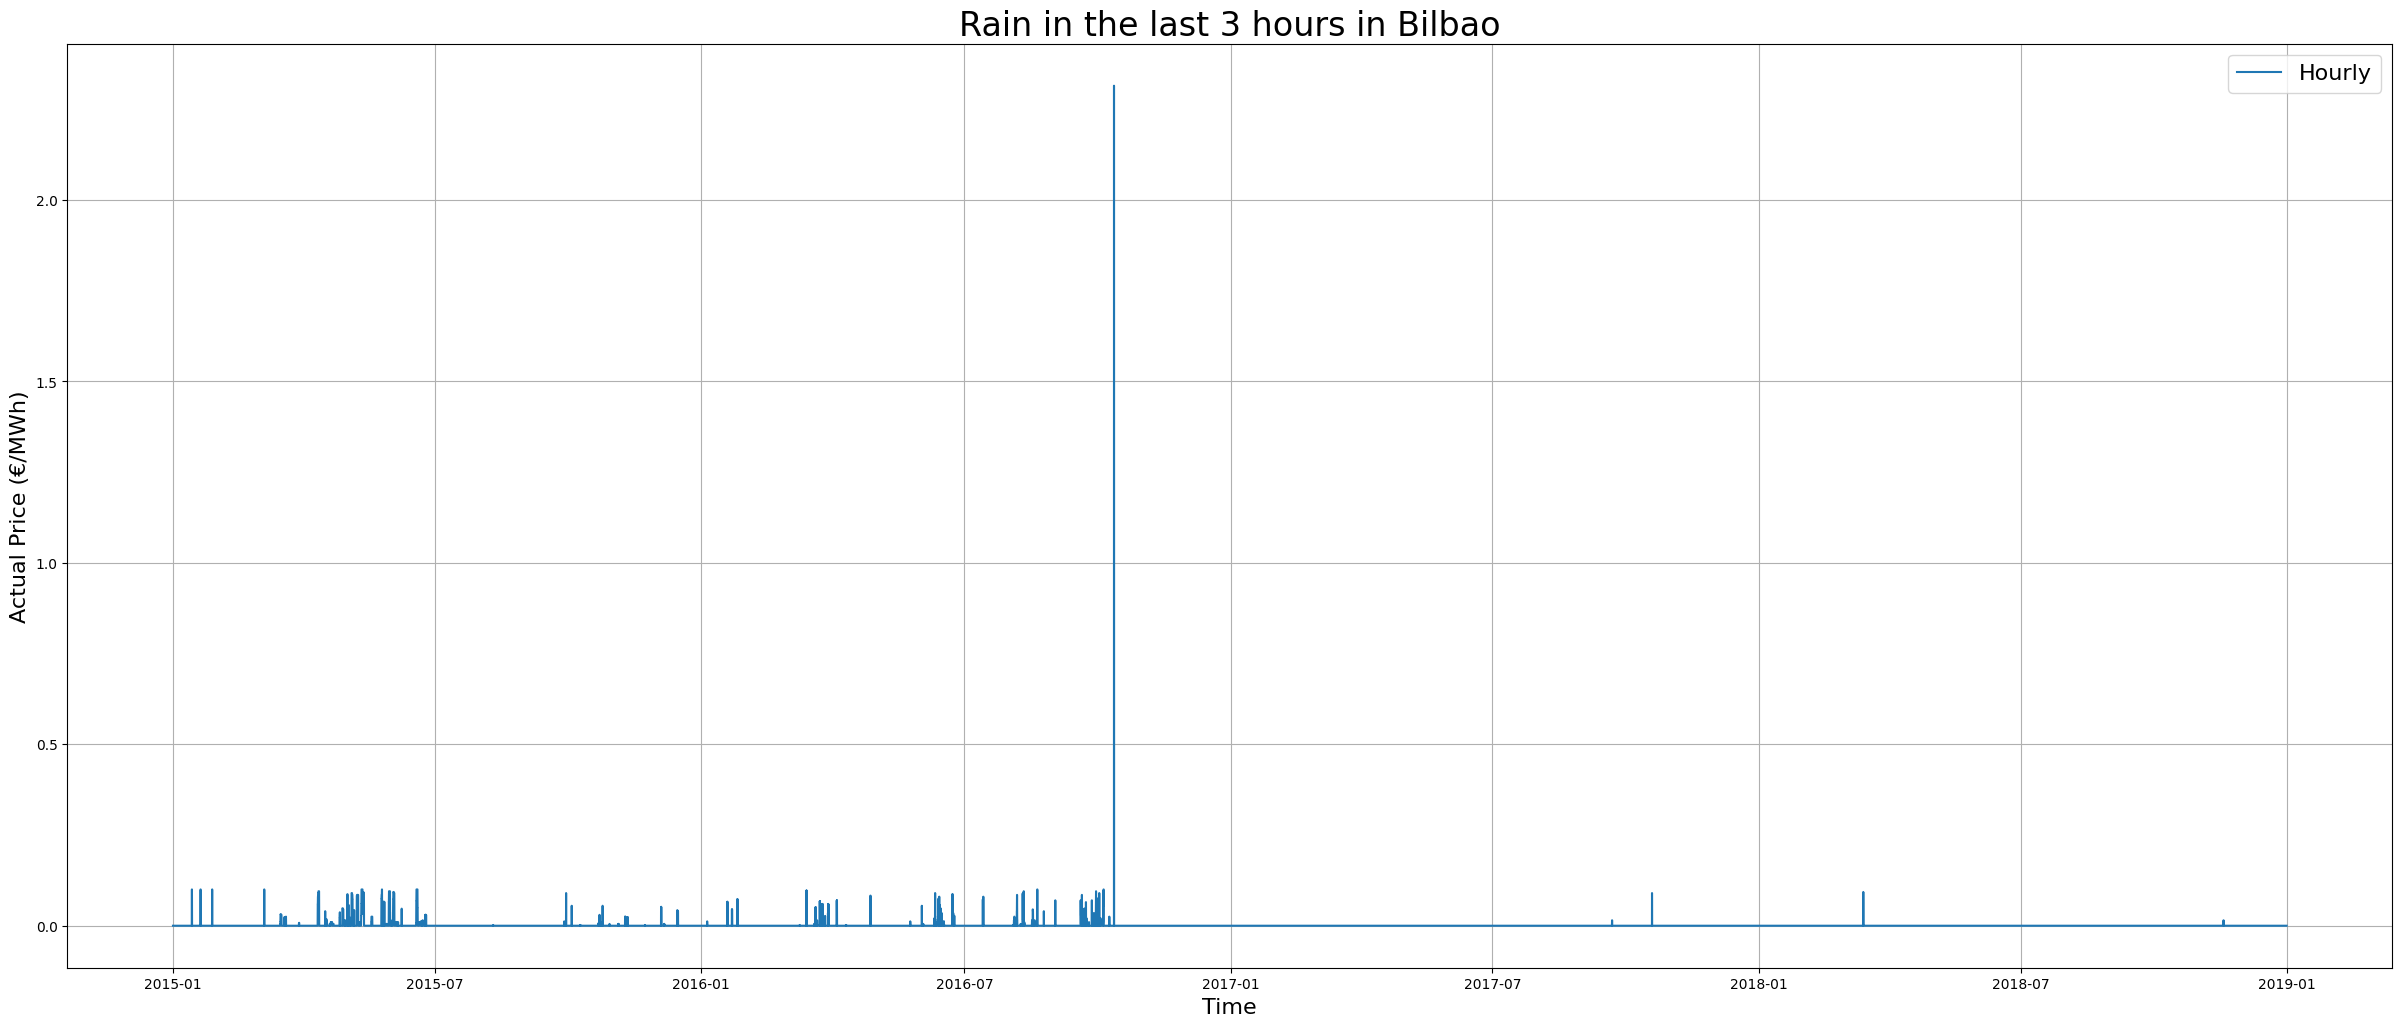

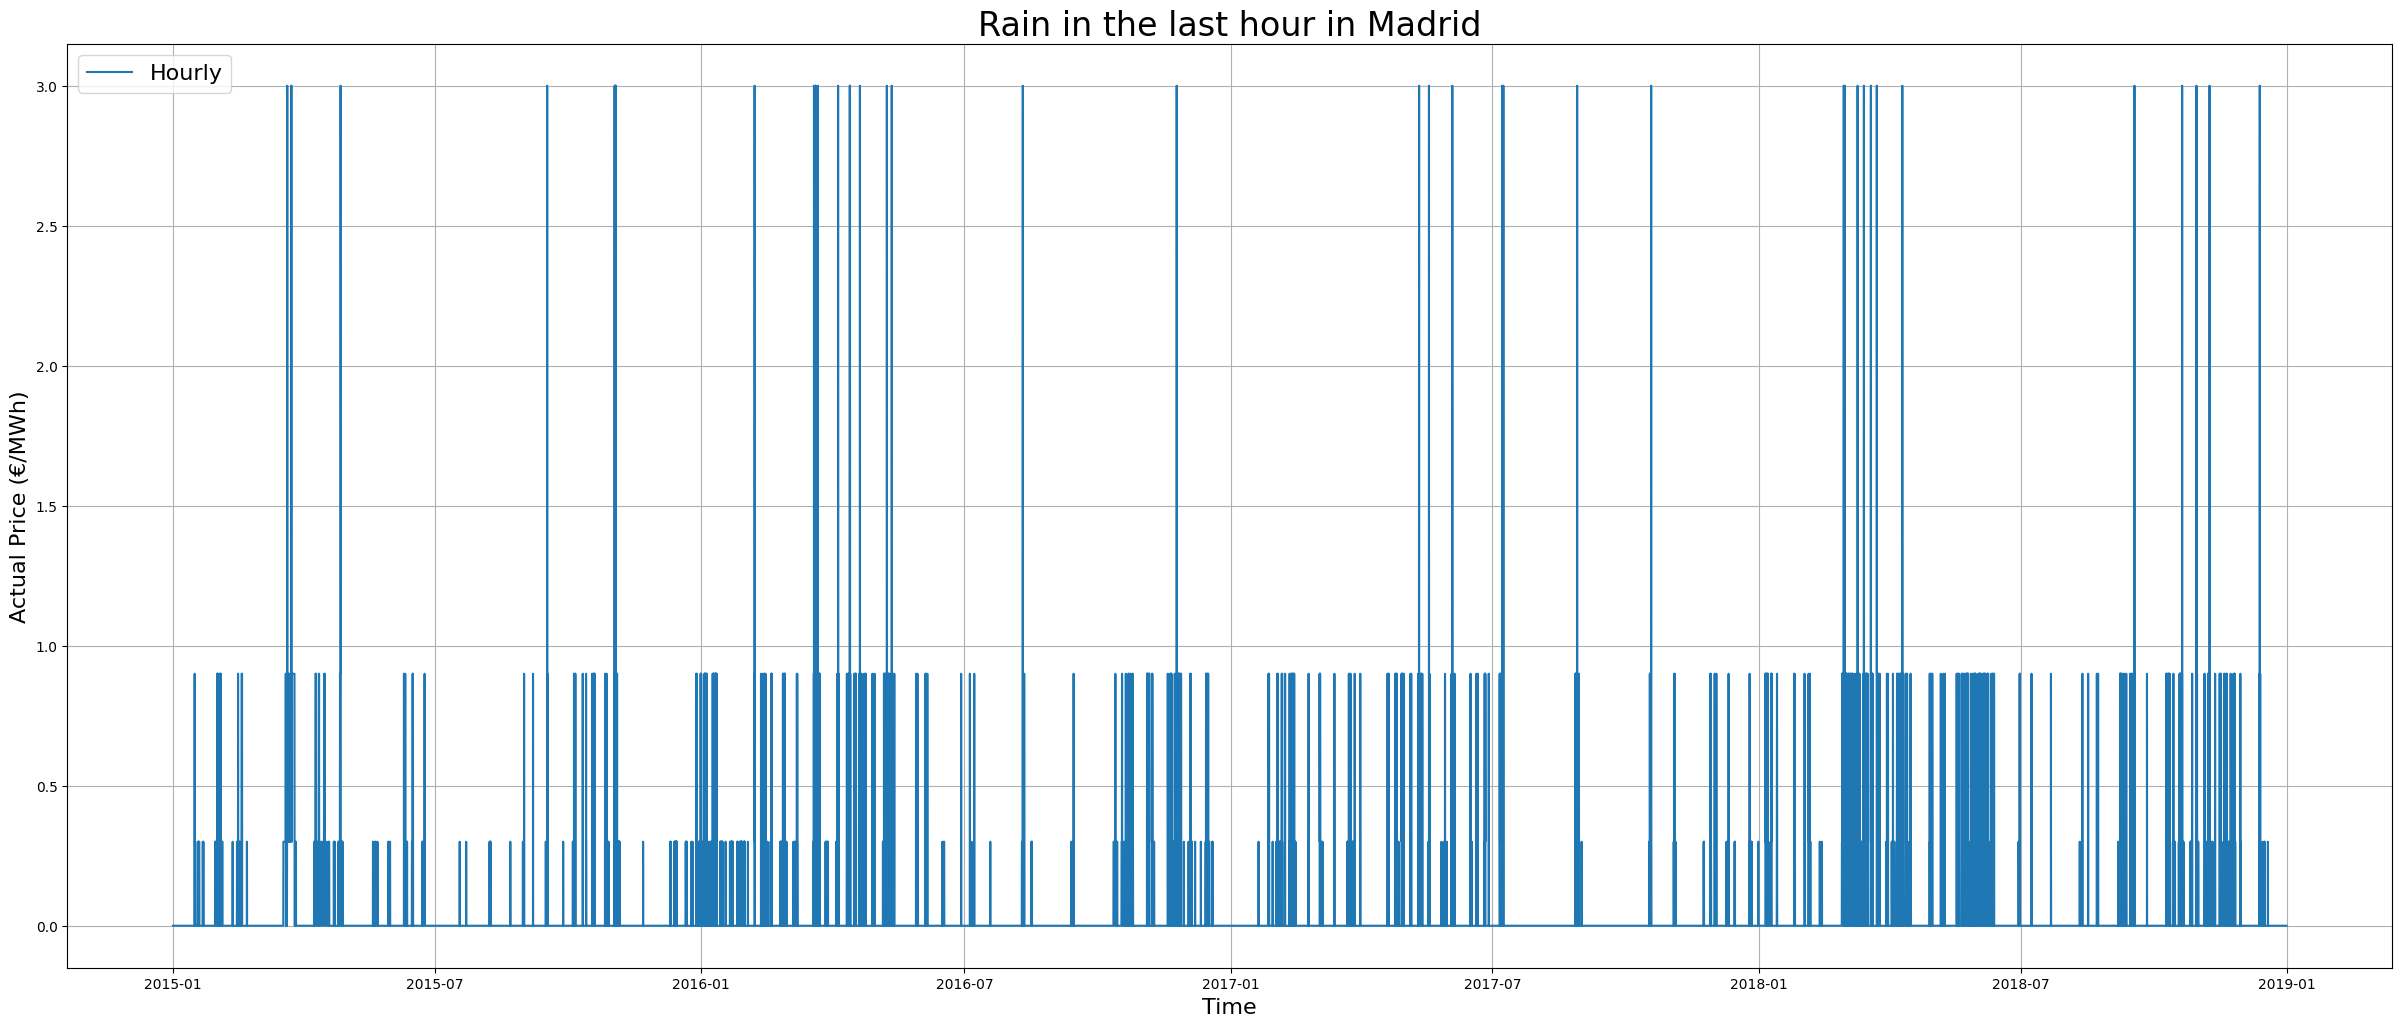

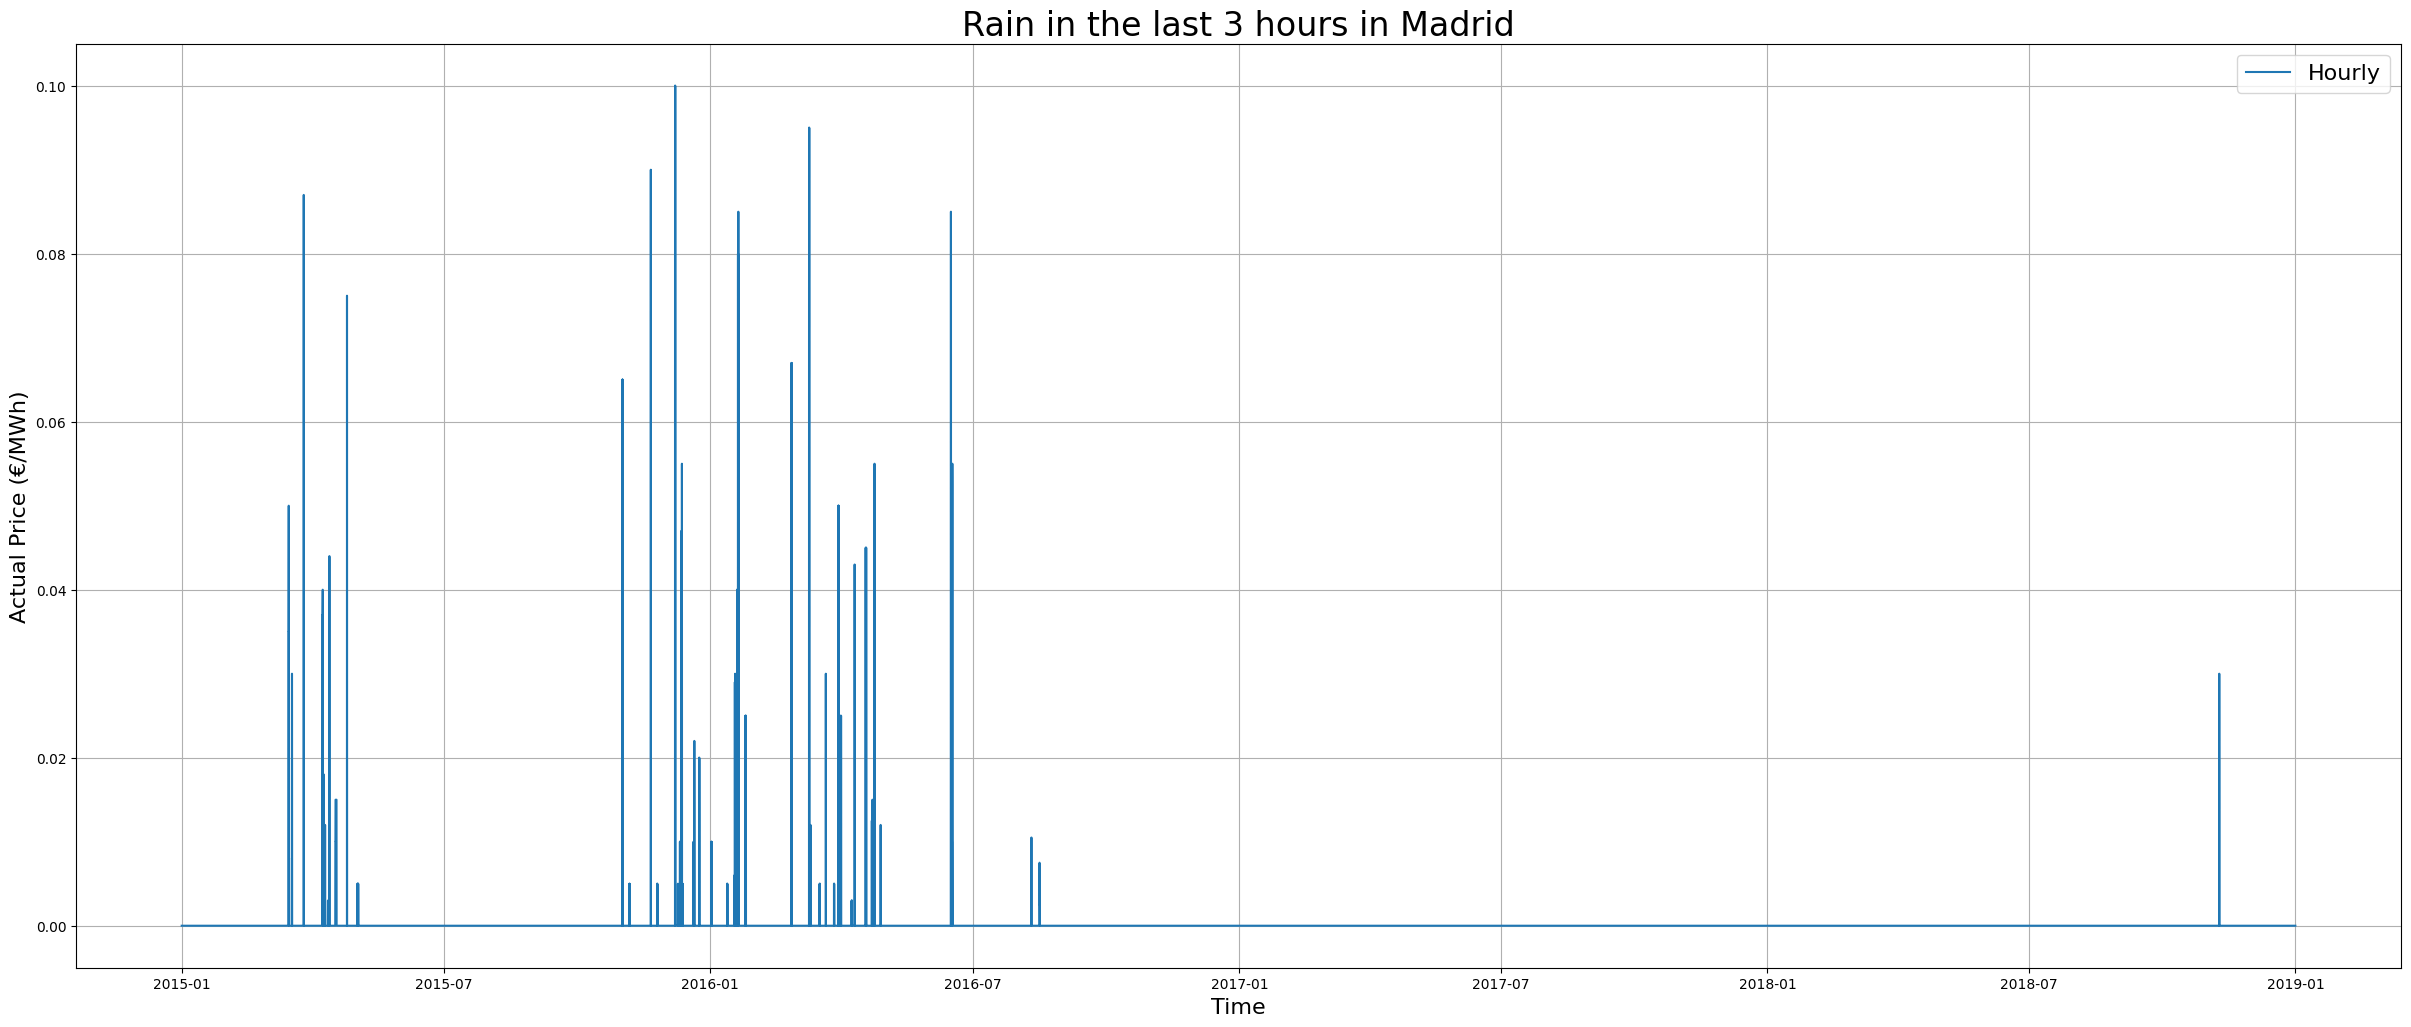

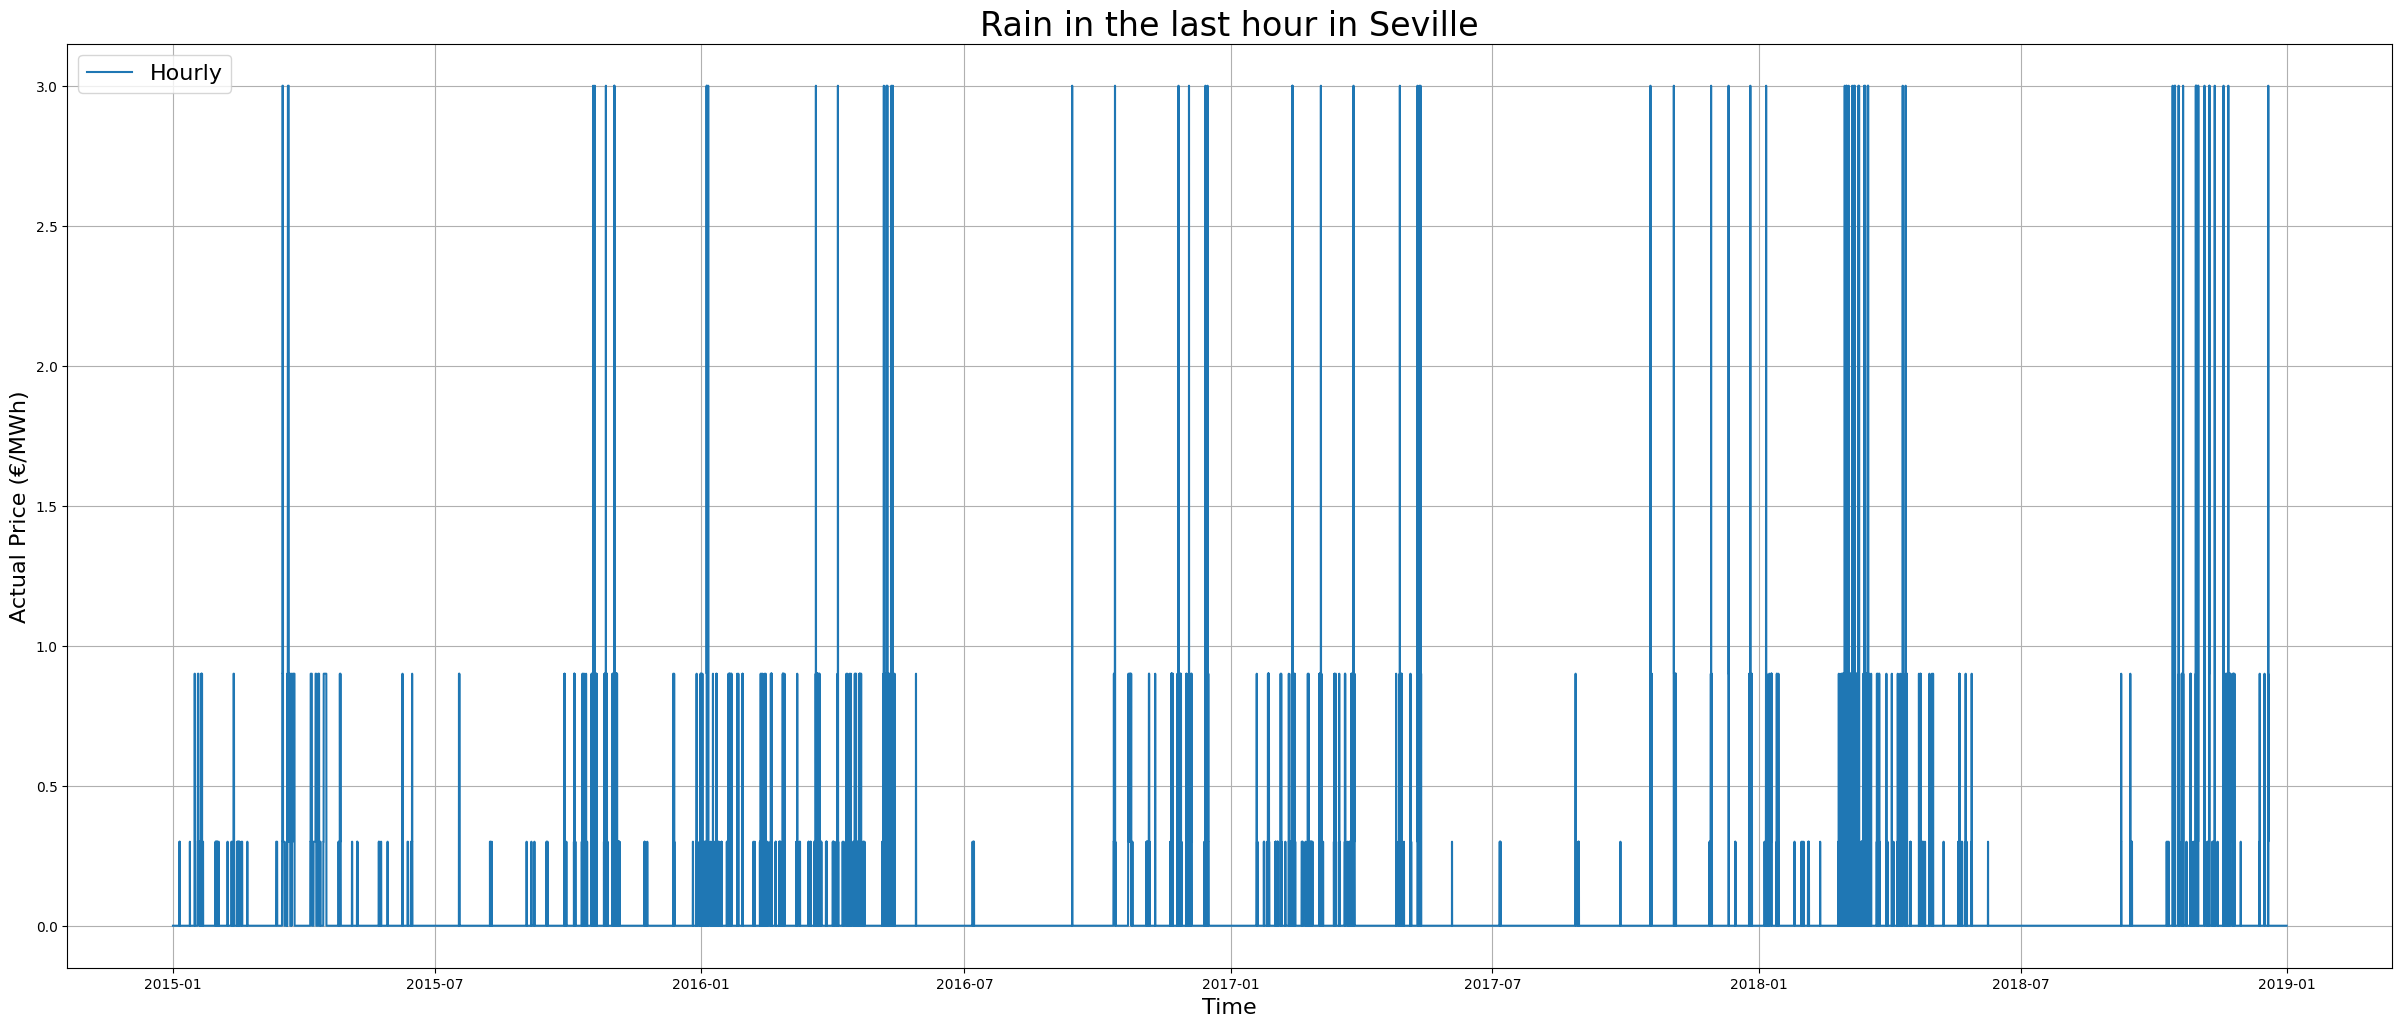

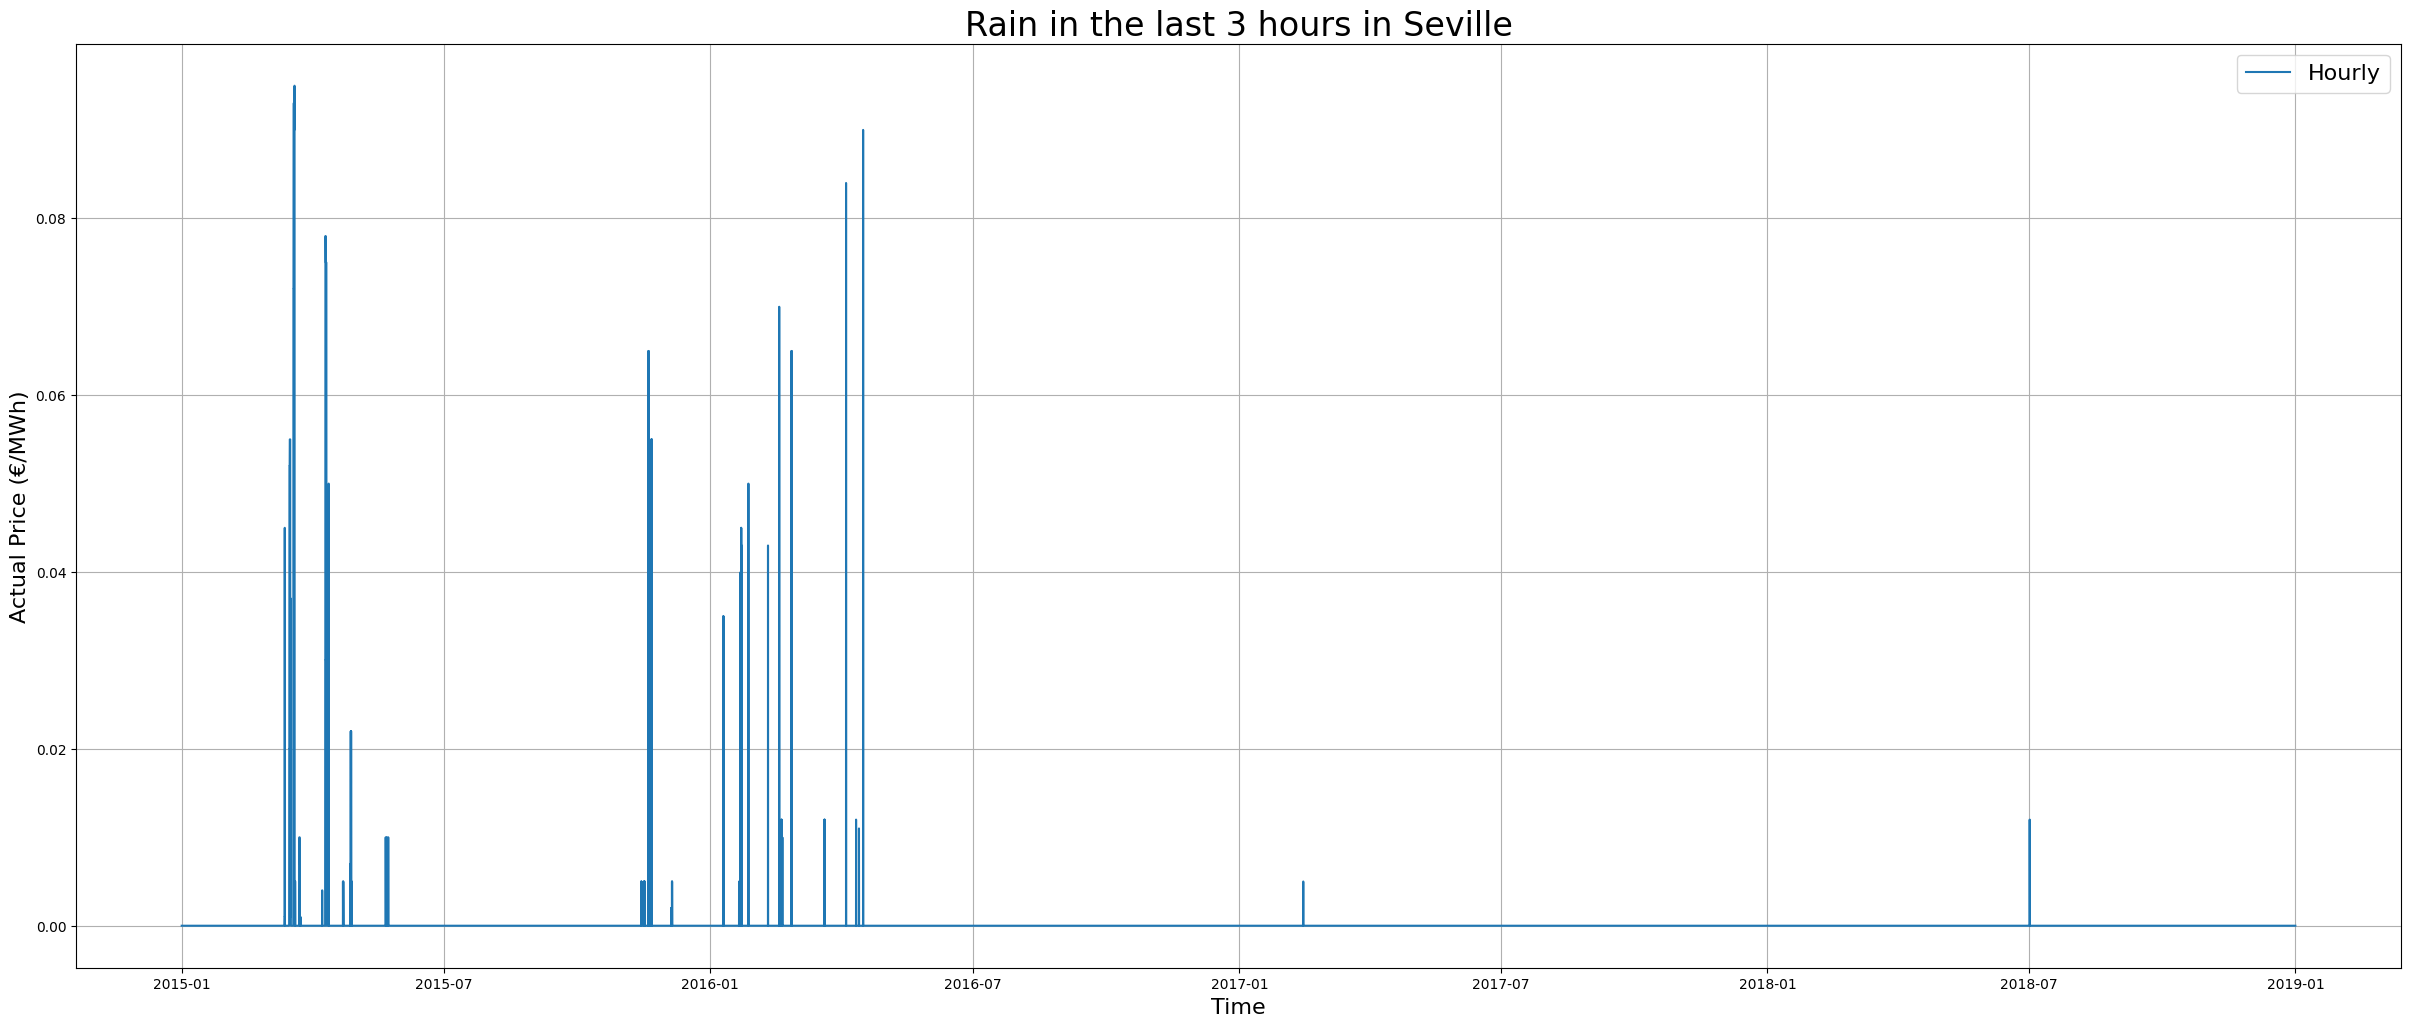

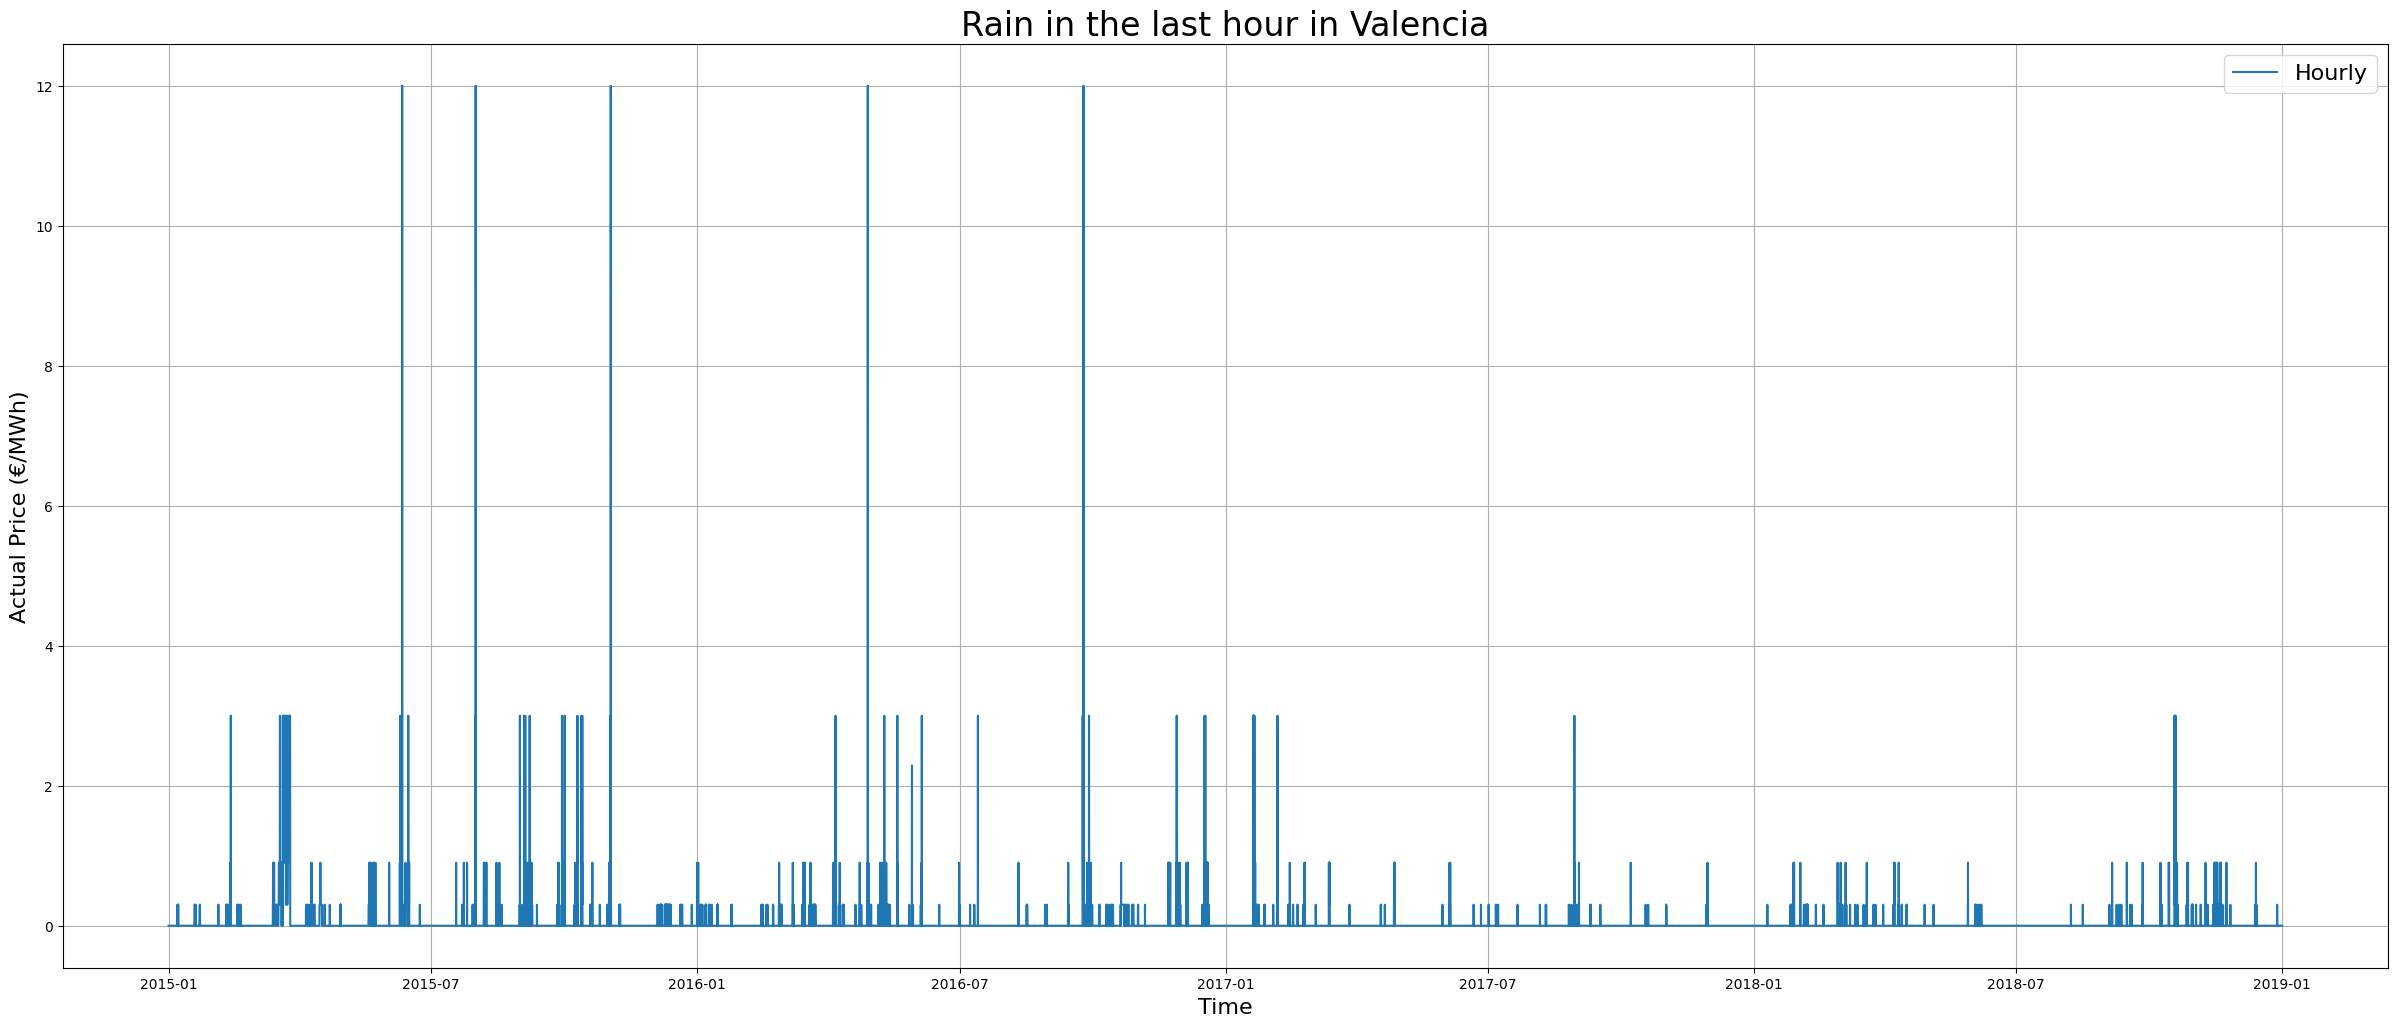

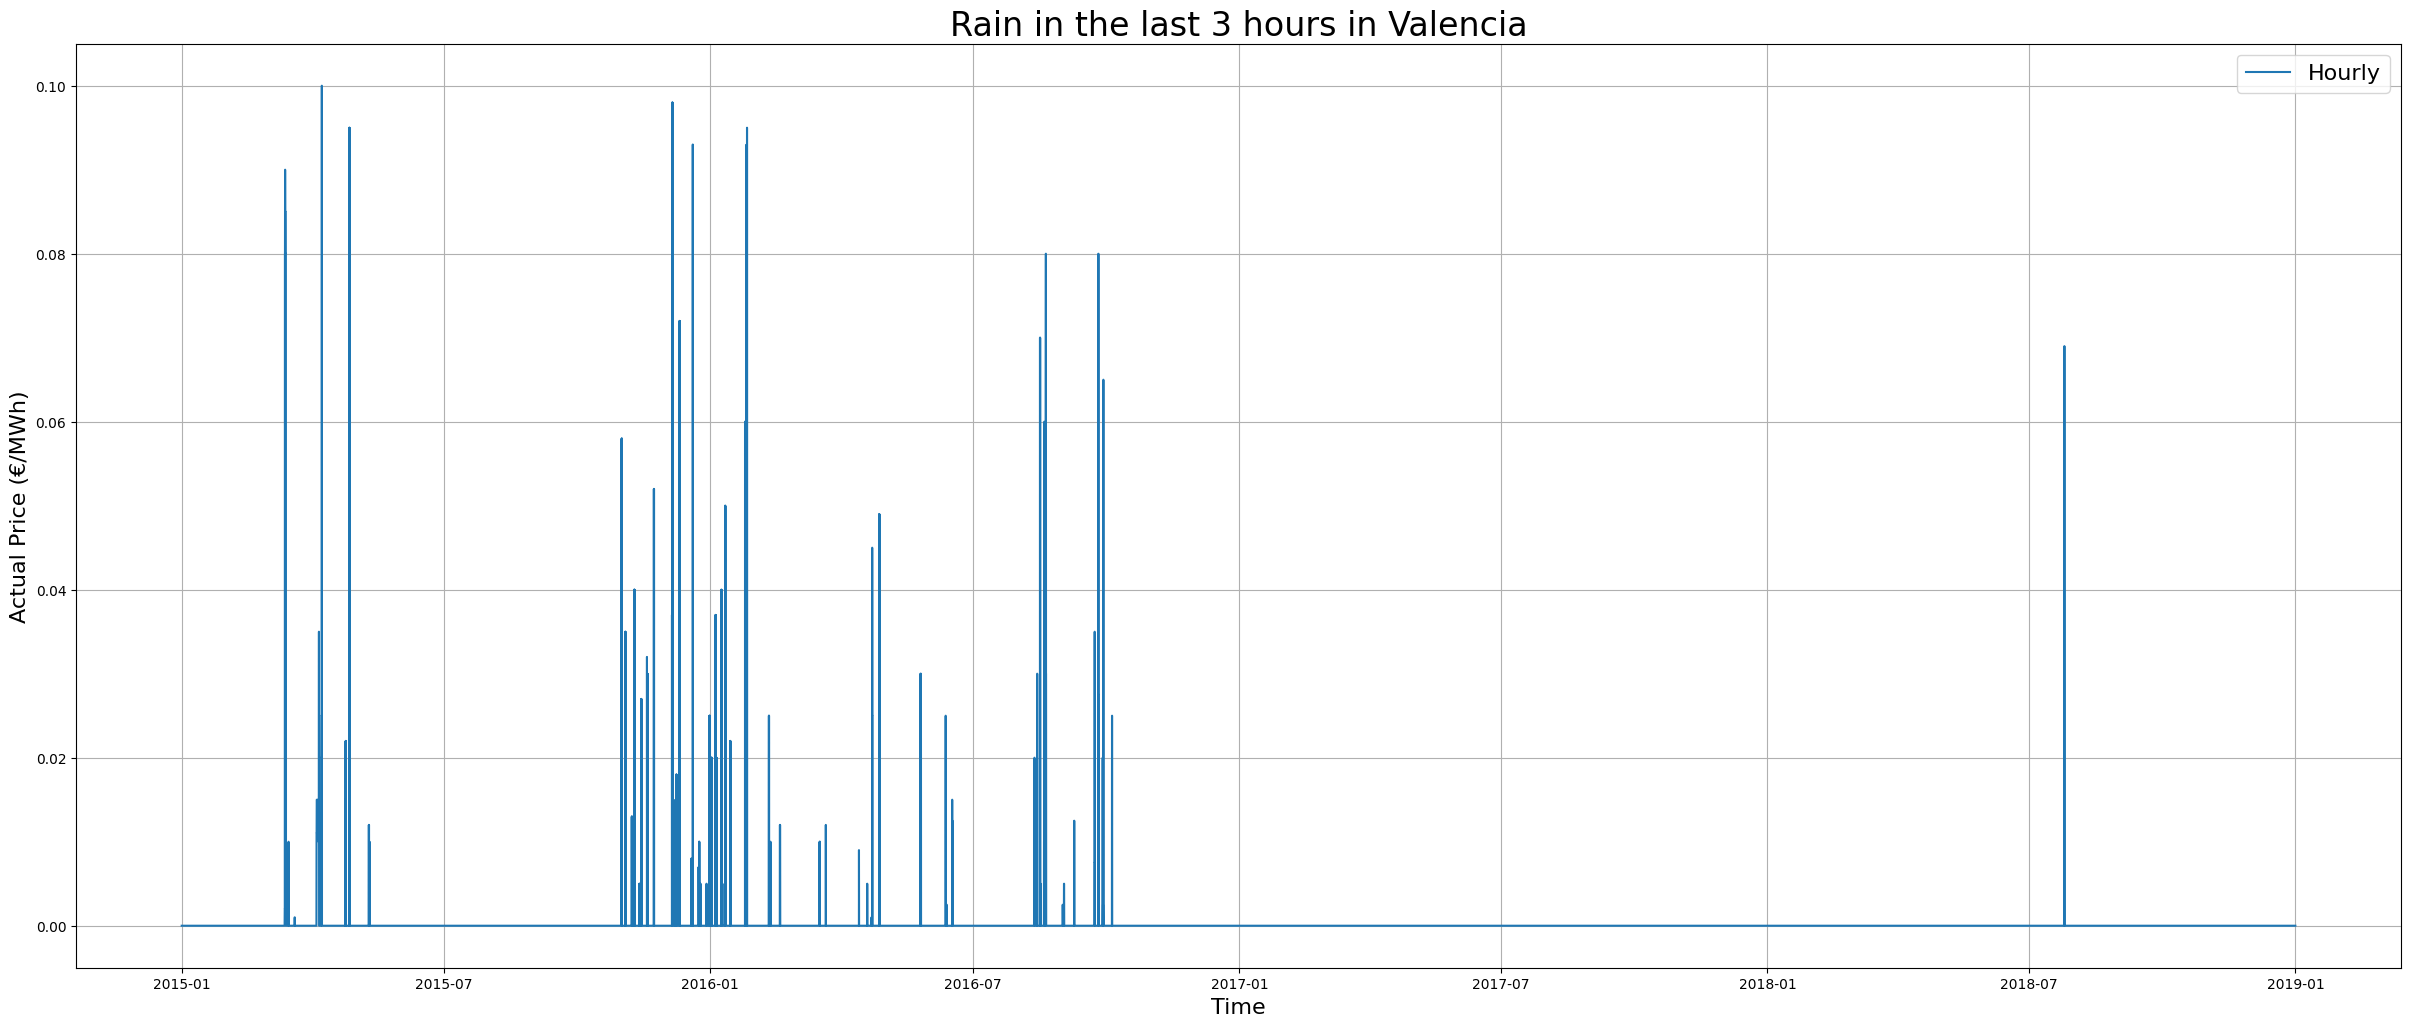

In [27]:
cities = ['Barcelona', 'Bilbao', 'Madrid', 'Seville', 'Valencia']

for city in cities:
    # Plot the 'rain_1h' for Bilbao
    ax = plot_ts(df, f'rain_1h_{city}', label = 'Hourly', ylabel = 'Actual Price (€/MWh)', title = f'Rain in the last hour in {city}')
    plt.show()

    # Plot the 'rain_3h' for Bilbao
    ax = plot_ts(df, f'rain_3h_{city}', label = 'Hourly', ylabel = 'Actual Price (€/MWh)', title = f'Rain in the last 3 hours in {city}')
    plt.show()

### Electricity price time series stationarity test

In [28]:
import statsmodels.api as sm

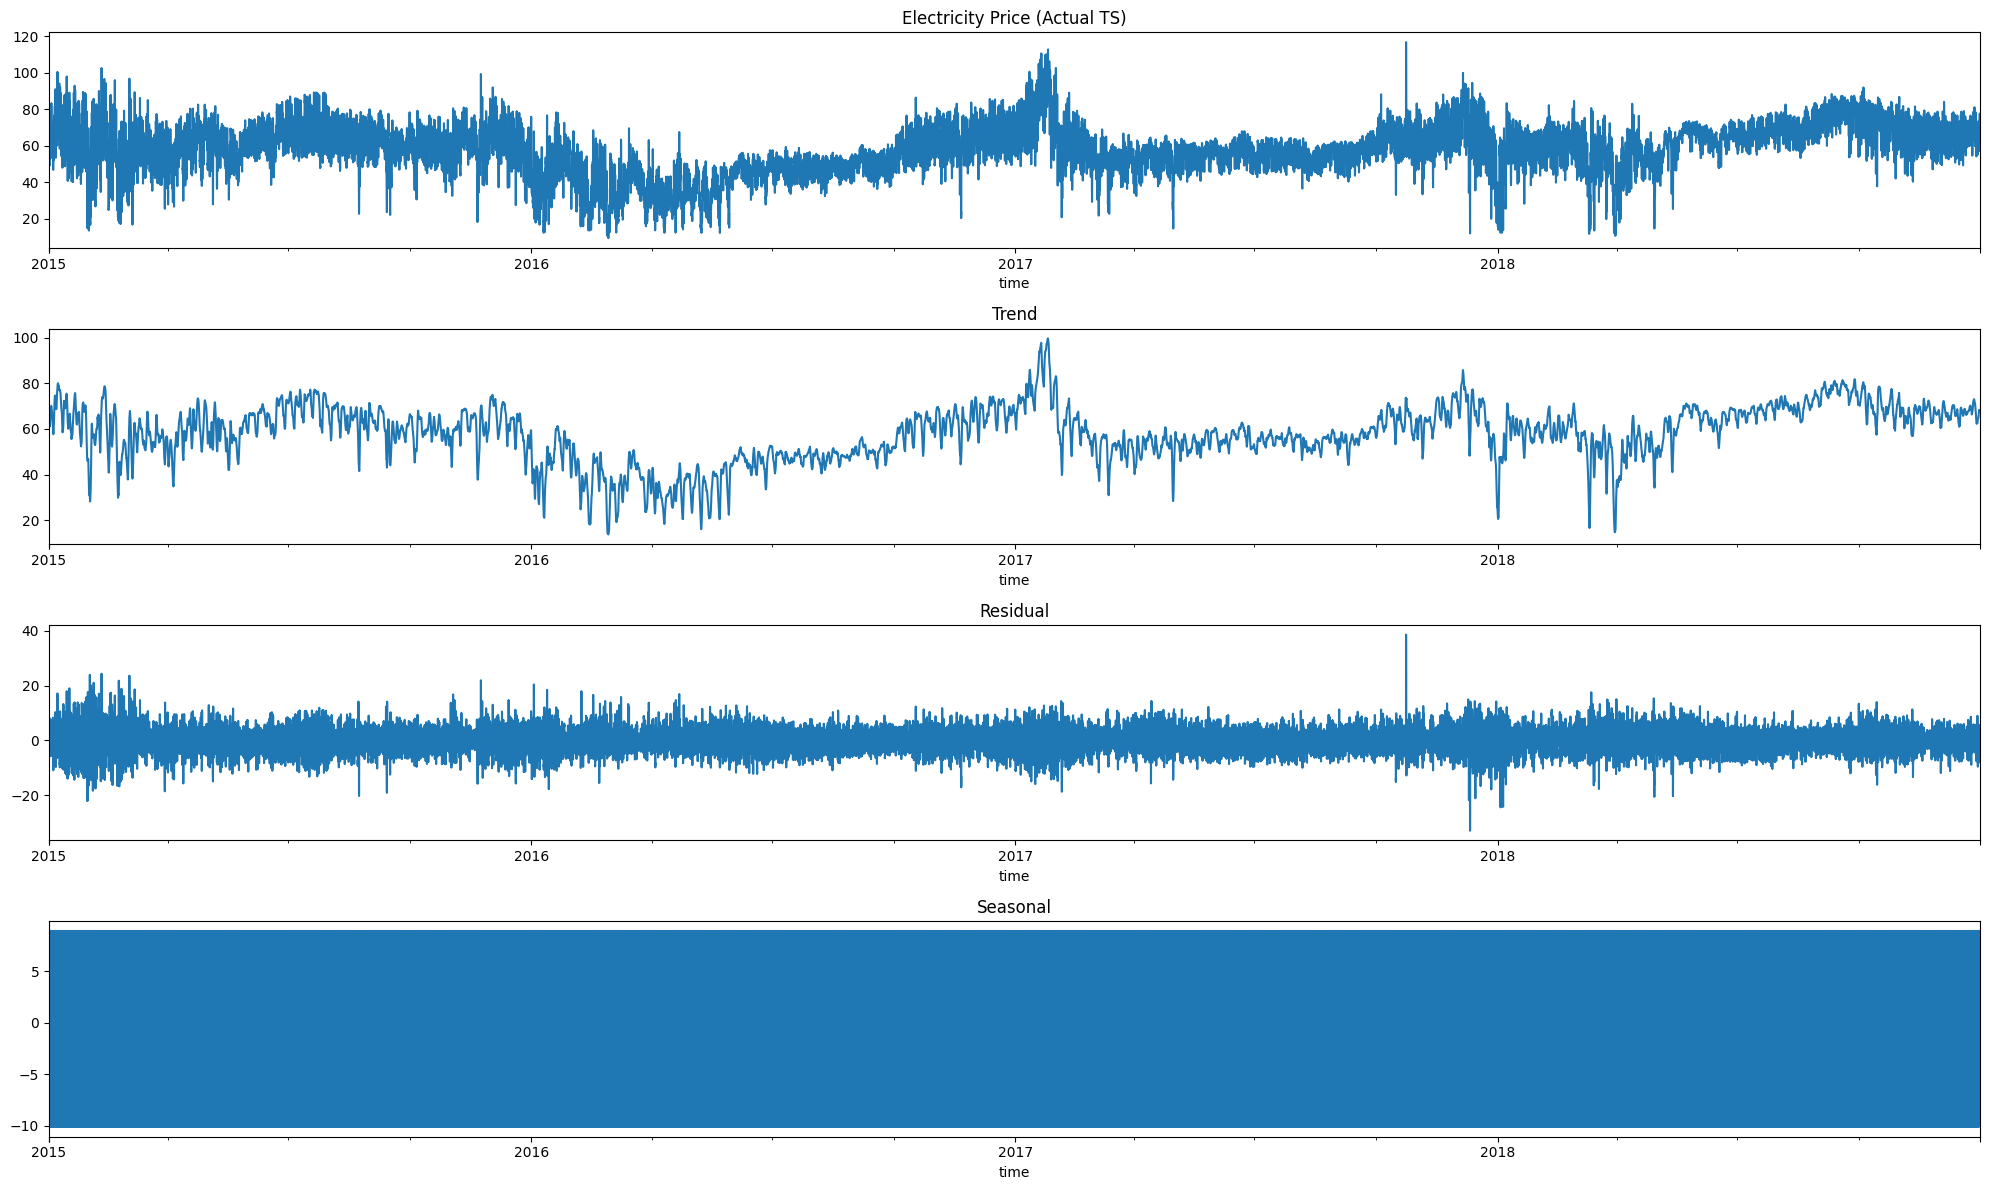

In [29]:
# Decompose the electricity price time series into a trend, a seasonal and a residual component while considering an additive model

res = sm.tsa.seasonal_decompose(df['price actual'], model = 'additive')

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 12))
res.observed.plot(ax=ax1, title='Electricity Price (Actual TS)')
res.trend.plot(ax=ax2, title='Trend')
res.resid.plot(ax=ax3, title='Residual')
res.seasonal.plot(ax=ax4, title='Seasonal')
plt.tight_layout()
plt.show()

We test the stationarity of the electricty price ("price actual" attribute) using the Augmented Dickey-Fuller (ADF) Test. \
H0: The time series is non-stationary \
Ha: The time series is stationary

In [30]:
from statsmodels.tsa.stattools import adfuller

In [31]:
adf_test = adfuller(df['price actual'], regression = 'c')

print(f"ADF Statistic: {adf_test[0]:.6f} \np-value: {adf_test[1]:.6f} \nNumber of lags used: {adf_test[2]}")

for key, value in adf_test[4].items():
    print('Critical Value ({}): {:.6f}'.format(key, value))

ADF Statistic: -9.147016 
p-value: 0.000000 
Number of lags used: 50
Critical Value (1%): -3.430537
Critical Value (5%): -2.861623
Critical Value (10%): -2.566814


The ADF statistic is less than the critical value at the 1% significance level; therefore, we reject the null hypothesis H0H0​ with 99% confidence. Thus, the electricity price time series is considered stationary.

Next we check the correlation between "price actual" attribute and the other attributes. We start with a Pearson correlation to detect linear correlations, and then we use Spearman correlation to find non-linear correlations.

In [34]:
pearson_corr = df.corr(method='pearson')['price actual']
print("Pearson correlation:\n", pearson_corr.sort_values(ascending=False).to_string())

threshold = 0.7  # set your correlation threshold
high_corr = pearson_corr[pearson_corr.abs() > threshold].sort_values(ascending=False)
print("\nFeatures with correlation above threshold:\n", high_corr.to_string())

Pearson correlation:
 price actual                                  1.000000
price day ahead                               0.732155
generation fossil hard coal                   0.465637
generation fossil gas                         0.461452
total load actual                             0.435253
generation fossil oil                         0.285050
generation other renewable                    0.255551
pressure_Barcelona                            0.249177
pressure_Bilbao                               0.194063
generation waste                              0.168710
generation biomass                            0.142671
pressure_Valencia                             0.109812
generation other                              0.099914
generation solar                              0.098529
temp_Valencia                                 0.090505
pressure_Seville                              0.090162
temp_Madrid                                   0.087995
weather_description_Barcelona              

Some attributes show a NaN correlation value. We already know that there are no missing values in the dataset, thus either these attributes are of a type different than float or they have a unique value

In [35]:
# Check for constant columns (only one unique value)
print(df.nunique()[df.nunique() <= 1])

snow_3h_Barcelona    1
snow_3h_Seville      1
dtype: int64


In [36]:
# Drop snow_3h_Barcelona and snow_3h_Seville attributes
df = df.drop(['snow_3h_Barcelona', 'snow_3h_Seville'], axis=1)

In [37]:
# Check data types of columns
print(df.dtypes[df.dtypes != 'float64'])  # or just df.dtypes

weather_main_Barcelona           int64
weather_description_Barcelona    int64
weather_main_Bilbao              int64
weather_description_Bilbao       int64
weather_main_Madrid              int64
weather_description_Madrid       int64
weather_main_Seville             int64
weather_description_Seville      int64
weather_main_Valencia            int64
weather_description_Valencia     int64
dtype: object


In [38]:
spearman_corr = df.corr(method='spearman')['price actual']
print("\nSpearman correlation:\n", spearman_corr.sort_values(ascending=False).to_string())

threshold = 0.7  # set your correlation threshold
high_corr = spearman_corr[spearman_corr.abs() > threshold].sort_values(ascending=False)
print("\nFeatures with correlation above threshold:\n", high_corr.to_string())


Spearman correlation:
 price actual                                  1.000000
price day ahead                               0.744304
generation fossil gas                         0.515975
generation fossil hard coal                   0.459950
total load actual                             0.435375
generation fossil oil                         0.268233
generation other renewable                    0.247866
pressure_Barcelona                            0.194719
pressure_Bilbao                               0.168182
generation hydro water reservoir              0.159644
generation solar                              0.132857
pressure_Valencia                             0.127655
generation waste                              0.125539
generation other                              0.122421
generation biomass                            0.122352
pressure_Madrid                               0.109897
temp_Valencia                                 0.086413
weather_description_Barcelona            

In [ ]:
# Save the final dataframe
if False:
    df.to_csv('./data/final_dataset.csv', index = True) # (index = True) is used to conserve time attribute although it is considered as an index 